# Notebook Hannah

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython import display

## Hypothetisch terrein

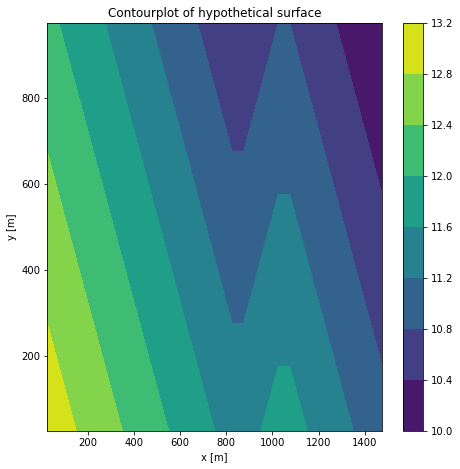

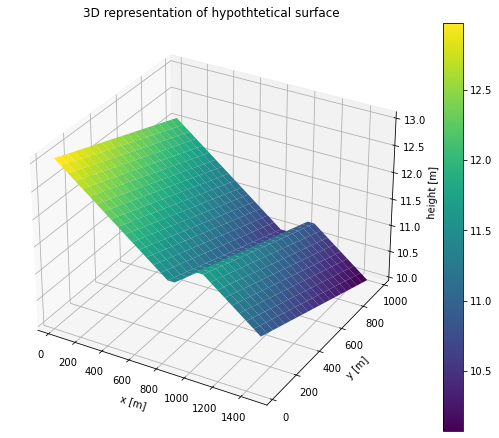

In [2]:
runfile('Grid_hypoth.py')
#convectie: grid[y,x] om zo met contour functies te kunnen werken!

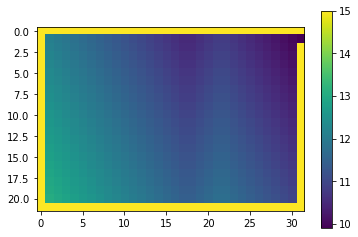

In [3]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = 15
grid_imag[:-1,-1] = 15
grid_imag[-2,-1] = grid[-1,-1] - (slopex*deltax) #dus wegdraineren met zelfde gradient
grid_imag[0,:] = 15
grid_imag[-1,:] = 15
plt.imshow(np.flipud(grid_imag))
plt.colorbar()

## Outfluxes 
Functie om de outflow fluxes per neighbourhood te berekenen met correctie.

In [4]:
def OutfluxNH(NH_h, NH_d, Acell, deltat, deltax, vmax_CFL):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - vmax_CFL: de maximaal toelaatbare snelheid volgens de CFL conditie
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                Fout[i] = v*dstar*deltax*deltat
            if v > vmax_CFL:
                raise Warning('Pas op: CFL conditie niet meer voldaan')
                ###deltat_v = deltax/v
            
    return Fout###, deltat_v

## Time loop
Met constante $\Delta$t.

In [31]:
# Parameters definiëren
Acell = deltax*deltay
deltat = 5 #constante tijdstap in s 
vmax_CFL = deltax/deltat #laat 10 m/s als maximale snelheid toe met deltax=50
tend = 5000
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t_list.append(deltat)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)

# Iteraties in de tijd
# Merk op: het heeft reeds 5 s geregend voor aanvang
for k in np.arange(2*deltat, tend, deltat):
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F1,F2,F4,F5 = OutfluxNH(NH_h, NH_d, Acell, deltat, deltax, vmax_CFL)
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    depths_imag_new[-2,-1] = 0 #uitstroomcel legen
    # Regenval toevoegen aan waterdiepte
    if k < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    
    t_list.append(k)
    depths_list.append(depths_imag_new)

/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_64020/2474753678.py:82: RuntimeWarning: invalid value encountered in double_scalars
  v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_64020/2474753678.py:83: RuntimeWarning: invalid value encountered in sqrt
  v_critical = np.sqrt(g*d)


Geen warning i.v.m. CFL conditie niet voldaan voor $\Delta$t, zodat de aanpassing van flux_calculation_NH naar flux_calculation_NH_exp mij niet nodig lijkt.

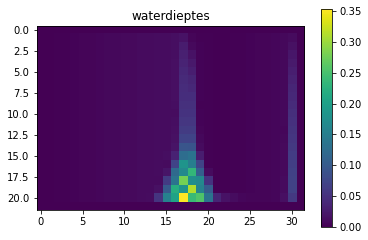

In [6]:
plt.figure()
plt.imshow(depths_list[-1])
plt.title('waterdieptes')
plt.colorbar()

## Animatie
Animeren van het resultaat van het vorige codeblock.

...................................................

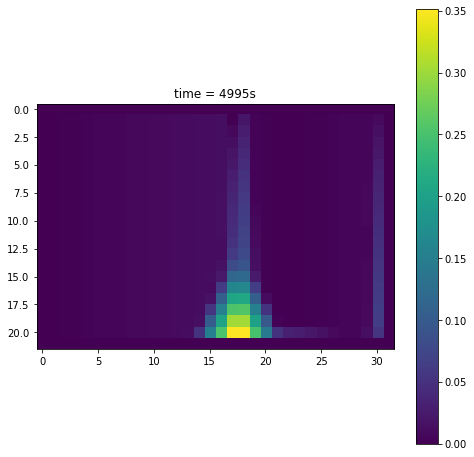

In [32]:
fps = 20
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('gif_constanteDeltat_oudePaper.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])

## Outflux functies en time loop voor variabele $\Delta$t

Aangepaste OutfluxNH functie voor de eerste loop; heeft geen $\Delta$t als input en berekent geen v*.

In [5]:
def OutfluxNH2_init(NH_h, NH_d, Acell, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Fysisch gelimiteerde snelheden (v's) berekenen en maximum opslaan
    v_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            v_list.append(v)
    if len(v_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vmax_NH = 0
    else:
        vmax_NH = np.max(v_list[:])
            
    return Fout, vmax_NH

Aangepaste OutfluxNH functie voor alle overige loops; heeft $\Delta$t uit de vorige loop als input en berekent op basis van de met v gecorrigeerde v* een nieuwe $\Delta$t.

In [6]:
def OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax):
    '''
    Berekent de flux naar elk van de naburige cellen.
    Vorm output: array van lengte 4 (F1, F2, F4, F5).
    Benodigde inputs (volgorde 1=>5 voor buren):
    - NH_h: de hoogtes van de DEM van de NH
    - NH_d: de waterdieptes van de NH
    - Acell: oppervlakte van 1 grid cell (constant!)
    - deltat: berekent in de vorige time loop
    '''
    watersurface_elv = NH_h + NH_d #sommeer de twee
    watersurface_elv_sorted = np.sort(watersurface_elv)
    indices_sorted = np.argsort(watersurface_elv)
    NH_d_sorted = NH_d[indices_sorted]
    DWLs = np.zeros(len(NH_d_sorted)-1)
    for i in range(len(DWLs)):
        DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]
    
    Vc = NH_d[2]*Acell #centrale cel = derde input
    rc = np.where(indices_sorted == 2)[0]
    
    # Berekening outflow volumes
    #DeltaVis = np.zeros(5) 
    #for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
        #if i != rc-1: #non-adjacent cells
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #DeltaVis[i]=np.min([term1,term2])
        #elif i == rc-1: #adjacent cell
            #term1 = Vc-np.sum(DeltaVis)
            #term2 = DWLs[i]*(i+1)*Acell
            #term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis)) #GROOT!
            #DeltaVis[i]=np.min([term1,term2,term3])

    # Andere manier (oude paper):
    DWLs_old = np.zeros(len(NH_d_sorted)-1) #andere definitie van DWLs in oude paper
    for i in range(len(DWLs_old)):
        DWLs_old[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]
    DeltaVis = np.zeros(5)
    for i in np.arange(0,int(rc)):
        term1 = Vc-np.sum(DeltaVis) 
        term2 = DWLs[i]*(i+1)*Acell
        term3 = (i+1)/(i+2)*(Acell*DWLs_old[i]-np.sum(DeltaVis))
        DeltaVis[i] = np.min([term1,term2,term3])
    
    # Berekening outflow fluxes
    Fluxes = np.zeros(5)
    for i in np.arange(0,int(rc)):
            for j in np.arange(i, int(rc)):
                Fluxes[i] = Fluxes[i] + DeltaVis[j]/(j+1) 
    # Fluxes toewijzen aan de juiste cellen (conventie figuur 1)
    F1 = Fluxes[indices_sorted == 0]
    F2 = Fluxes[indices_sorted == 1]
    F4 = Fluxes[indices_sorted == 3]
    F5 = Fluxes[indices_sorted == 4]

    Fout = np.hstack([F1,F2,F4,F5])
    
    # Flux correction
    vj_list = []
    WL_C = watersurface_elv[2] #central cell = derde input
    z_C = NH_h[2]
    d = NH_d[2] #water depth (in central cell?)
    R = d
    n = 0.01 #Manning's coefficient
    g = 9.81
    for i in range(len(Fout)):
        if Fout[i] != 0:
            if i < 2: #cellen rechts, boven hebben indices 0,1
                WL_N = watersurface_elv[i]
                z_N = NH_h[i]
            elif i > 1: #cellen onder, links hebben indices 3,4
                WL_N = watersurface_elv[i+1]
                z_N = NH_h[i+1]
            # Calculate vstar
            dstar = np.max([WL_C,WL_N])-np.max([z_C,z_N])
            if dstar != 0:
                vstar = Fout[i]/(dstar*deltax*deltat)
            elif dstar == 0: #deling door 0 voorkomen
                vstar = 0
            # Calculate v
            S = (WL_C-WL_N)/deltax #geen onderscheid deltax/deltay voor vierkante cellen!
            v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
            v_critical = np.sqrt(g*d)
            v = np.min([v_Mannings, v_critical])
            # Flux recalculation if necessary
            if vstar > v:
                vj_list.append(v)
                Fout[i] = v*dstar*deltax*deltat
            else:
                vj_list.append(vstar)
    if len(vj_list)==0: #np.max kan niet toegepast worden op een lege lijst
        vjmax_NH = 0
    else:
        vjmax_NH = np.max(vj_list[:])
    
    return Fout, vjmax_NH

Time loop:

In [14]:
# Parameters definiëren
Acell = deltax*deltay
tend = 100000
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
depths_imag = np.zeros((ny+2,nx+2))
t = 10*60
depths_imag[1:-1,1:-1] = rain*t #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)


##1## Eerste iteratie in de tijd => functie OutfluxNH2_init
fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
depths_imag = depths_list[-1]
depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
vmax_list = []
for j in np.arange(1,ny+1):
    for i in np.arange(1,nx+1):
        # Hoogtes in neighbourhood
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
        # Waterdieptes in neighbourhood
        dneigb1 = depths_imag[j,i+1]
        dneigb2 = depths_imag[j+1,i]
        dneigb3 = depths_imag[j,i]
        dneigb4 = depths_imag[j-1,i]
        dneigb5 = depths_imag[j,i-1]
        NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
        # Outflow fluxes berekenen
        F,vmax_NH = OutfluxNH2_init(NH_h, NH_d, Acell, deltax)
        F1 = F[0]
        F2 = F[1]
        F4 = F[2]
        F5 = F[3]
        # Toekennen van totale outflow flux centrale cel (!)
        F3 = -F1-F2-F4-F5 
        fluxes_imag[2,j,i] = F3
        # Toekennen van inflow fluxes naburige cellen
        fluxes_imag[3,j,i+1] = F1
        fluxes_imag[4,j+1,i] = F2
        fluxes_imag[0,j-1,i] = F4
        fluxes_imag[1,j,i-1] = F5
        # vmax_NH opslaan in lijst
        vmax_list.append(vmax_NH)
    
# Globale tijdstap updaten
deltat = deltax/np.max(vmax_list[:])
print(deltat)
t = t + deltat
t_list.append(t)
    
depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
depths_imag_new[-2,-1] = 0 #uitstroomcel legen
# Regenval toevoegen aan waterdiepte
if t < duration: #alleen in het eerste uur
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
elif t > duration and (t-deltat) < duration:
    depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration-(t-deltat))
depths_list.append(depths_imag_new)


##2## Overige iteraties in de tijd => functie OutfluxNH2
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    vjmax_list = []
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F,vjmax_NH = OutfluxNH2(NH_h, NH_d, Acell, deltat, deltax)
            F1 = F[0]
            F2 = F[1]
            F4 = F[2]
            F5 = F[3]
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # vmax_NH opslaan in lijst
            vjmax_list.append(vjmax_NH)
      
    # Globale tijdstap updaten
    deltat = deltax/np.max(vjmax_list[:])
    print(deltat)
    t = t + deltat
    t_list.append(t)
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    depths_imag_new[-2,-1] = 0 #uitstroomcel legen
    # Regenval toevoegen aan waterdiepte
    if t < duration: #alleen in het eerste uur
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*deltat
    elif t > duration and (t-deltat) < duration:
        depths_imag_new[1:-1,1:-1] = depths_imag_new[1:-1,1:-1] + rain*(duration-(t-deltat))
    depths_list.append(depths_imag_new)

492.8888079942049
492.88880799417905
492.88880799414494
492.88880799410555
492.88880799404194
492.88880799399493
492.88880799394104
492.88880799390057
492.88880799382196
492.8888079937846
492.88880799372987
492.88880799366234
492.88880799360044
492.88880799354456
492.8888079935289
492.88880799348294
492.8888079934661
492.8888079933848


/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_66344/3956386872.py:83: RuntimeWarning: invalid value encountered in double_scalars
  v_Mannings = (1/n)*(R**(2/3))*(S**(1/2))
/var/folders/9y/8pbbm58j5qb0ppd8hrfwlbv00000gn/T/ipykernel_66344/3956386872.py:84: RuntimeWarning: invalid value encountered in sqrt
  v_critical = np.sqrt(g*d)


492.8888079933592
492.8888079933395
492.8888079932444
492.88880799317917
492.8888079909074
492.8888079908789
492.888807990789
492.8888079903619
492.88880799027504
492.8888079896076
492.88880798935395
492.8888079892272
492.8888079890918
492.8888079890373
492.8888079889435
492.88880798887556
492.8888079888535
492.8888079884869
263.31863140529475
263.3186314051621
263.31863140495614
263.3186314049194
263.31863140393943
263.3186314038097
258.95489285790006
258.9548928578643
258.9548928578326
258.95489285627536
258.95489285350163
258.9548928428623
258.9548928428292
258.95489284269627
258.95489284259
258.9548928425745
258.9548928422715
258.9548928422302
258.9548928420831
258.95489284203546
258.9548928361827
233.18137732354856
233.1813773234721
233.18137732326326
233.18137732279556
233.18137732270407
233.18137732268522
233.18137730874636
233.1813773086934
233.18137730863413
233.18137730851763
233.18137730846786
231.41433947630338
231.41433947620308
231.4143394761857
231.41433947547205
231.414

.....................

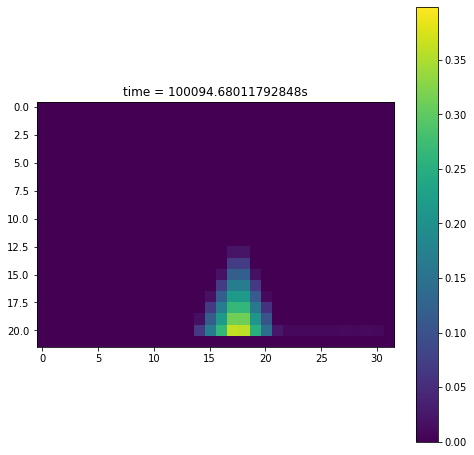

In [15]:
fps = 20
#nSeconds = 5
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure( figsize=(8,8) )
fig, ax = plt.subplots(figsize = (8,8))


a = depths_list[0]
im = plt.imshow(a, interpolation='none', vmin=0, vmax=np.max(depths_list[:]))
plt.colorbar(im)


def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(depths_list[i])
    ax.set_title('time = '+str(t_list[i]) + 's')
    
    return [im]

anim = animation.FuncAnimation(fig, animate_func, frames = len(depths_list), interval = 1000 / fps) # in ms)
anim.save('gif_variabeleDeltat.gif', writer= 'pillow', fps=fps)# extra_args=['-vcodec', 'libx264'])

## Experiment met $\Delta$t
Ik heb het script behorend bij de aangepaste flux_calculation functie (###) hieronder eens proberen uit te schrijven, maar heb er nog vragen bij...

In [ ]:
# Parameters definiëren
Acell = deltax*deltay
deltat = 5 #constante tijdstap in s 
vmax_CFL = deltax/deltat #laat 10 m/s als maximale snelheid toe met deltax=50
tend = 5000
rain = 20/(1000*3600) #regenval in m/s
duration = 3600 
theta = 0.7 #relaxatieparameter (gekalibreerd)

# Initialisatie
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h
t_list = [] #lijst met tijdstappen
t = deltat
t_list.append(t)
depths_list = [] #lijst met waterdieptes voor alle tijdstap
depths_list.append(depths_imag)

# Iteraties in de tijd
while t < tend:
    fluxes_imag = np.zeros((5,ny+2,nx+2)) #elke cell ontvangt 5 fluxen: 4 positieve en 1 negatieve (!)
    depths_imag = depths_list[-1]
    depths_imag_new = np.zeros((ny+2,nx+2)) #of np.copy(depths_imag)
    deltat_new = [] ##aanpassing
    # V: deltat_new voor elke tijdstap updaten?
    for j in np.arange(1,ny+1):
        for i in np.arange(1,nx+1):
            # Hoogtes in neighbourhood
            hneigb1 = grid_imag[j,i+1]
            hneigb2 = grid_imag[j+1,i]
            hneigb3 = grid_imag[j,i]
            hneigb4 = grid_imag[j-1,i]
            hneigb5 = grid_imag[j,i-1]
            NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
            # Waterdieptes in neighbourhood
            dneigb1 = depths_imag[j,i+1]
            dneigb2 = depths_imag[j+1,i]
            dneigb3 = depths_imag[j,i]
            dneigb4 = depths_imag[j-1,i]
            dneigb5 = depths_imag[j,i-1]
            NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])
            # Outflow fluxes berekenen
            F1,F2,F4,F5,deltat_v = OutfluxNH(NH_h, NH_d, Acell, deltat, deltax, vmax_CFL)
            # Toekennen van totale outflow flux centrale cel (!)
            F3 = -F1-F2-F4-F5 
            fluxes_imag[2,j,i] = F3
            # Toekennen van inflow fluxes naburige cellen
            fluxes_imag[3,j,i+1] = F1
            fluxes_imag[4,j+1,i] = F2
            fluxes_imag[0,j-1,i] = F4
            fluxes_imag[1,j,i-1] = F5
            # Deltat_v opslaan 
            deltat_new.append(delta_v) ##aanpassing
            
    depths_imag_new = np.copy(depths_imag) + theta*np.sum(fluxes_imag,axis=0)/Acell
    depths_imag_new[-2,-1] = 0 #uitstroomcel legen
    deltat = np.min(np.array(deltat_new)) ##aanpassing
    t = t + deltat 
    t_list.append(t)
    depths_list.append(depths_imag_new)

## Klad (@Olivier negeer dit)

### Toepassen functie OutflowNBH

In [31]:
fluxes_imag = np.zeros((4,ny+2,nx+2)) #elke cell ontvangt max. 4 fluxen 
depths_imag = np.zeros((ny+2,nx+2))
depths_imag[1:-1,1:-1] = rain*deltat #waterdiepte na 5s regenval aan 20 mm/h

j = 10
i = 10
# Hoogtes in neighbourhood
hneigb1 = grid_imag[j,i+1]
hneigb2 = grid_imag[j+1,i]
hneigb3 = grid_imag[j,i]
hneigb4 = grid_imag[j-1,i]
hneigb5 = grid_imag[j,i-1]
NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
# Waterdieptes in neighbourhood
dneigb1 = depths_imag[j,i+1]
dneigb2 = depths_imag[j+1,i]
dneigb3 = depths_imag[j,i]
dneigb4 = depths_imag[j-1,i]
dneigb5 = depths_imag[j,i-1]
NH_d = np.hstack([dneigb1,dneigb2,dneigb3,dneigb4,dneigb5])

# Outflow fluxes berekenen
out = OutfluxNH(NH_h, NH_d, Acell, deltat, deltax, vmax_CFL)
#np.seterr()

UnboundLocalError: local variable 'deltat_v' referenced before assignment

### Verschil DeltaVis berekening

In [ ]:
# Recentste paper
NH_h = np.array([11.35, 11.4, 11.45, 11.5, 11.55])
#NH_d = np.repeat(20000/(1000*3600), 5)
NH_d = np.array([0.00005, 0.0001, 0.001, 0.001, 0.001])
Acell = 50*50

watersurface_elv = NH_h + NH_d #sommeer de twee
indices_sorted = np.argsort(watersurface_elv)
watersurface_elv_sorted = np.sort(watersurface_elv)
NH_d_sorted = NH_d[indices_sorted]
DWLs = np.zeros(len(NH_d_sorted)-1)
for i in range(len(DWLs)):
    DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]

Vc = NH_d[2]*Acell #centrale cel = derde input
rc = np.where(indices_sorted == 2)[0]
DeltaVis = np.zeros(4) 
for i in np.arange(0,int(rc)): #volgorde: van lage naar hoge water surface elevation
    if i != rc-1: #non-adjacent cells
        term1 = Vc-np.sum(DeltaVis)
        term2 = DWLs[i]*(i+1)*Acell
        DeltaVis[i]=np.min([term1,term2])
    elif i == rc-1: #adjacent cell
            term1 = Vc-np.sum(DeltaVis)
            term2 = DWLs[i]*(i+1)*Acell
            term3 = (i+1)*Acell/Acell + (i+1)*Acell*(Vc-np.sum(DeltaVis))
            DeltaVis[i]=np.min([term1,term2,term3])
Vc, DeltaVis, term1, term2, term3

In [ ]:
# Oude paper:
NH_h = np.array([11.34, 11.4, 11.45, 11.5, 11.55])
#NH_d = np.repeat(20000/(1000*3600), 5)
NH_d = np.array([0.00005, 0.0001, 0.001, 0.001, 0.001])
Acell = 50*50

watersurface_elv = NH_h + NH_d #sommeer de twee
indices_sorted = np.argsort(watersurface_elv)
watersurface_elv_sorted = np.sort(watersurface_elv)
NH_d_sorted = NH_d[indices_sorted]
DWLs = np.zeros(len(NH_d_sorted)-1)
for i in range(len(DWLs)):
    DWLs[i] = watersurface_elv_sorted[i+1]-watersurface_elv_sorted[i]

#de 3 termen uit vgl (1) van Flood_analysis_bispdf
dc = NH_d[2] #we definiëren centrale cell altijd als 3e input!, = d0
V0 = dc*Acell
rc = np.where(indices_sorted == 2)[0]   #rank of the central cell

#oude paper (flood_analysis_bis) maakt gebruik van andere definitie van DWLS
DWLsold = np.zeros(len(NH_d_sorted)-1)
for i in range(len(DWLs)):
    DWLsold[i] = watersurface_elv_sorted[rc] - watersurface_elv_sorted[i]

DeltaVis = np.zeros(5)
for i in np.arange(0,int(rc)):
    term1 = V0 - np.sum(DeltaVis) #wat kan gegeven worden
    term2 = (i+1)/(i+2)*(Acell*DWLsold[i]-np.sum(DeltaVis))    #aanpassen omdat onze i één waarde lager
    term3 = (i+1)*Acell*DWLs[i] #hier gebruik van formule uit onze paper, deze is equivalent
    #met formule uit oude paper aangezien DWLs bij ons gedefinieerd als verschil tussen 2 lagen (terwijl in oude paper)
    #als verschil met centrale lage. Idee term3: wat beschikbaar is
    DeltaVis[i] = np.min([term1,term2,term3])
V0, DeltaVis, term1, term2, term3
indices_sorted